# Constructing and analyzing graphs for real data

#### In this notebook, we are going to use information related to research articles on Diabetes 2 that have been scraped from pubmed (see the PubMed Scraper notebook on how to do that).








In [ ]:
import os
import shutil
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Import the gensim library for topic modeling and other NLP tasks
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import igraph as ig
import cairo

# Import pyLDAvis and pyLDAvis.gensim for LDA visualization
import pyLDAvis.gensim
# Import pickle for saving and loading Python objects
import pickle
# Import pyLDAvis for LDA visualization
import pyLDAvis


nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

In [30]:
# read data
data = pd.read_csv('type+2+diabetes_500.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [32]:
# let's have a look
data.head(3)

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations
0,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...","genetic factor, intervention trial., lifestyle...","""1. Lab of Molecular Immunology, Zhejiang Prov..."
1,"N. Javeed and AV. Matveyenko,","""Circadian Etiology of Type 2 Diabetes Mellitu...",Mar. 2018,"""The epidemic of Type 2 diabetes mellitus nece...",NaN,"""Department of Physiology and Biomedical Engin..."
2,"B. Fletcher, M. Gulanick and C. Lamendola,","""Risk factors for type 2 diabetes mellitus."",",Jan. 2002,"""Genetic, environmental, and metabolic risk fa...",NaN,"""University of North Florida, Department of Nu..."


In [33]:
# Find number of non-nan entries for each column
data.count()

Authors         485
ArticleTitle    500
Date            485
Abstract        189
Keywords         62
Affiliations    322
dtype: int64

Step 1: Clean the data. We'll make topics based on the keywords column and later use these as well as publication year to construct a graph

In [35]:
# drop rows where date column is nan
data = data.dropna(subset=['Date'])
# drop rows where date column is 'nan
data = data[data['Date'] != 'nan']

# only include the year in the date for simplicity
data['Date'] = data['Date'].apply(lambda x: str(x)[-4:]).astype(int)

# In the following, we will make topics based on the keywords column. You could instead choose to work with the abstract column.
data.dropna(subset=['Keywords'], inplace=True)


In [39]:
# Remove common words such as me, our, you etc.
stop_words = nltk.corpus.stopwords.words('english')

# Add some more stopwords, i.e. words to be removed
new_stopwords = ['diabetes', 'type', 'mellitus']
stop_words.extend(new_stopwords)

from string import punctuation
print("List of words to be removed: ", stop_words)

# Decapitalize text
data['Keywords'] = data['Keywords'].apply(lambda x: x.lower())
# Remove numbers
data['Keywords'] = data['Keywords'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
# Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
data['Keywords'] = data['Keywords'].apply(lambda x: tokenizer.tokenize(x))
# remove stop words
data['Keywords'] = data['Keywords'].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))

print("\nFirst five rows of the text column after preprocessing:")
print("\n",data['Keywords'].head())

List of words to be removed:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [40]:
# Define a function to find unique words in a text
def find_unique_words(text, word_list):
    for word in text.split():
        if word not in word_list:
            word_list.append(word)
    return

In [41]:
# Let's find the no. of words and no. of unique words in the dataset

# Number of words in dataset
Nwords = data['Keywords'].apply(lambda x: len(x.split()));
unique_words_before_lemmatization = []

for row in data['Keywords']:
    find_unique_words(row, unique_words_before_lemmatization)

Nunique_words_before_lemmatization = len(unique_words_before_lemmatization);
# sort unique words
unique_words = sorted(unique_words_before_lemmatization);

print("Number of words in dataset: ", Nwords.sum())
print("Number of unique words in dataset: ", Nunique_words_before_lemmatization)
print(" The first 100 unique words: ", unique_words[:100])

Number of words in dataset:  456
Number of unique words in dataset:  298
 The first 100 unique words:  ['abnormal', 'acid', 'activity', 'activité', 'acute', 'ada', 'adherence', 'adolescent', 'adult', 'adverse', 'age', 'agents', 'aging', 'akt', 'alimentaire', 'almond', 'america', 'amino', 'anti', 'antihistamine', 'anxiety', 'apnea', 'arabic', 'arhgef', 'artery', 'assessment', 'atherosclerosis', 'austria', 'balance', 'bcaa', 'behaviour', 'bio', 'blood', 'bmi', 'body', 'branch', 'cancer', 'cardiovasculaire', 'cardiovascular', 'care', 'case', 'catenin', 'centered', 'chain', 'child', 'children', 'china', 'cholesterol', 'chutes', 'circadian', 'clinical', 'cliniques', 'clock', 'cognitive', 'collaborative', 'community', 'comorbidities', 'comorbidity', 'complication', 'complications', 'comportement', 'control', 'controlled', 'coronary', 'cost', 'cov', 'covid', 'cvd', 'data', 'de', 'delivery', 'depression', 'diabetic', 'diabète', 'diagnosis', 'diet', 'dietary', 'directed', 'disc', 'disease', 'di

c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


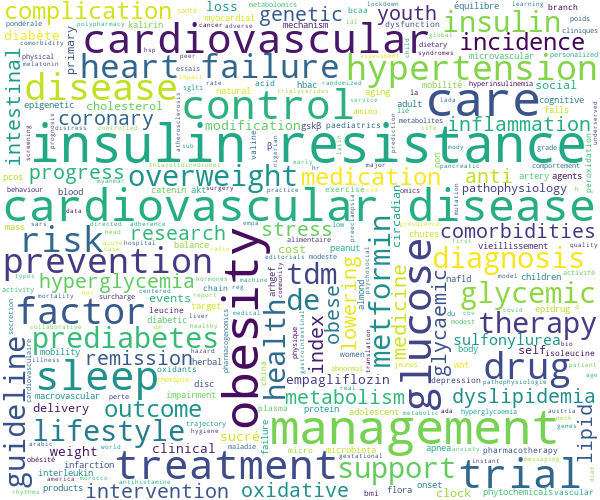

In [42]:
# Join the different processed titles together.
long_string = ','.join(list(data['Keywords'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',  width = 600, height = 500)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [43]:
# Define a function to convert sentences to words
def sent_to_words(sentences):
    # Loop over each sentence in the list of sentences
    for sentence in sentences:
        # Use gensim's simple_preprocess to convert the sentence to a list of words.
        # The 'deacc=True' argument removes punctuations.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Get the 'text' column values from the 'data' DataFrame as a list
data_words = data.Keywords.values.tolist()

# Apply the 'sent_to_words' function to preprocess the data
# The result is a list of lists, where each inner list contains words from a sentence
data_words = list(sent_to_words(data_words))

In [44]:
# Create a Dictionary from the processed data_words
# The Dictionary object maps each unique word in the data to a unique integer ID
id2word = corpora.Dictionary(data_words)

# Create a Corpus using the original preprocessed data_words
# In this context, a "corpus" is simply a collection of documents (texts)
texts = data_words

# Create a Term Document Frequency corpus using the Dictionary
# 'doc2bow' counts the number of occurrences of each distinct word and converts the word to its integer ID
# The corpus is a list of vectors, one vector per document
corpus = [id2word.doc2bow(text) for text in texts]

# View a portion of the corpus to understand its structure
# The corpus is a list of lists, where each inner list contains tuples (word ID, word frequency) for a document
# The following line prints the all word IDs and frequencices for the first document in the corpus
print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [45]:
# Set the number of topics to be extracted by the LDA model
num_topics = 3

# Build the LDA model using gensim's LdaMulticore
# 'corpus' contains the bag-of-words representation of each document
# 'id2word' is a dictionary that maps word IDs to actual words
# 'num_topics' specifies the number of topics to be extracted
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=42)

# Pretty-print the topics extracted by the LDA model
# Each topic is represented as a list of keywords and their associated weights
pprint(lda_model.print_topics())

# Apply the LDA model to the corpus to transform each document into a distribution of topics
# 'doc_lda' will contain the topic distribution for each document in the corpus
doc_lda = lda_model[corpus]

[(0,
  '0.020*"cardiovascular" + 0.020*"resistance" + 0.019*"insulin" + '
  '0.019*"care" + 0.013*"management" + 0.012*"treatment" + 0.010*"risk" + '
  '0.010*"control" + 0.010*"glucose" + 0.010*"obesity"'),
 (1,
  '0.018*"sleep" + 0.016*"incidence" + 0.015*"glycemic" + 0.015*"management" + '
  '0.015*"control" + 0.013*"cardiovascular" + 0.013*"support" + '
  '0.011*"insulin" + 0.011*"tdm" + 0.009*"cholesterol"'),
 (2,
  '0.027*"disease" + 0.017*"insulin" + 0.016*"obesity" + 0.016*"prevention" + '
  '0.015*"cardiovascular" + 0.012*"drug" + 0.012*"prediabetes" + '
  '0.012*"hypertension" + 0.011*"trials" + 0.011*"failure"')]


In [46]:
# Name topics
topic_0 = 'symptoms'
topic_1 = 'management'
topic_2 = 'risk factors'
topic_list = [topic_0, topic_1, topic_2]

In [47]:
# Enable the notebook mode for pyLDAvis# This allows for interactive topic model visualization inline in a Jupyter Notebook
pyLDAvis.enable_notebook()

# Construct the filepath where the pre-prepared LDA visualization data will be saved
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))

# This block prepares LDA visualization and saves it
# The if statement here is always True (1 == 1), so the block will always execute
if 1 == 1:
    # Prepare LDA visualization using the LDA model, corpus, and dictionary
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    # Save the prepared visualization data to disk using pickle
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared LDA visualization data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Save the LDA visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

# Display the prepared LDA visualization
# Note: This would display the interactive LDA visualization inline if run in a Jupyter Notebook
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.030842  0.052051       1        1  41.296257
2     -0.077292 -0.006565       2        1  36.365640
1      0.046450 -0.045486       3        1  22.338102, topic_info=             Term      Freq     Total Category  logprob  loglift
230     incidence  2.000000  2.000000  Default  30.0000  30.0000
64          sleep  3.000000  3.000000  Default  29.0000  29.0000
52       glycemic  2.000000  2.000000  Default  28.0000  28.0000
42        control  3.000000  3.000000  Default  27.0000  27.0000
83     prevention  3.000000  3.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
137            de  0.674716  2.399298   Topic3  -4.9971   0.2302
80      metformin  0.667408  2.300033   Topic3  -5.0080   0.2616
114  inflammation  0.653762  1.789166   Topic3  -5.0287   0.4921
61   hypertension  0.656749  2.913480   Topic3  -5.0241   0.0091
53          index  0.648841  1.702889   Topic3  -5.0363   0.5340

[181 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
221       3  0.915501      adherence
7         2  0.833265         agents
50        3  0.915427         almond
238       3  0.915257  antihistamine
194       1  0.771907        anxiety
...     ...       ...            ...
131       2  0.837759         trials
281       2  0.832257          types
226       3  0.914846    underserved
117       3  0.915063       vascular
99        2  0.561832          youth

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

The doc_lda contains the probability that each document belong to each of the topics. We are going to add this data to the dataframe

In [48]:
# Construct array of topic probabilities for each document in the corpus
topic_probability_array = np.zeros([len(data), num_topics])
main_topic_list = []

# extract topic probabilities for each document
for i, doc in enumerate(doc_lda):
    for topic in doc:
        topic_probability_array[i, topic[0]] = topic[1]
    main_topic_list.append(topic_list[np.argmax(topic_probability_array[i, :])])

# add topic probabilities to dataframe
for topic in topic_list:
    #data['Main Topic'] = topic_probability_array[np.argmax(topic_probability_array, axis=1)]
    
    data[f"Topic: {topic}"] = topic_probability_array[:, topic_list.index(topic)]

# add main topic to dataframe
data['Main topic'] = main_topic_list

In [72]:
# let's have a look
data.head(3)

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations,Topic: symptoms,Topic: management,Topic: risk factors,Main topic
0,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...",genetic factor intervention trial lifestyle tr...,"""1. Lab of Molecular Immunology, Zhejiang Prov...",0.898579,0.050625,0.050797,symptoms
6,"RJ. Henning,","""Type-2 diabetes mellitus and cardiovascular d...",2018,"""The global prevalence of diabetes has risen i...",hbac adult onset coronary artery disease gluco...,"""University of South Florida, Tampa, FL 33612-...",0.016267,0.015503,0.968230,risk factors
7,"J. Damanik and E. Yunir,","""Type 2 Diabetes Mellitus and Cognitive Impair...",2021,"""Type 2 diabetes mellitus (T2DM) is strongly a...",cognitive impairment,"""Department of Internal Medicine, Faculty of M...",0.112508,0.112902,0.774590,risk factors


In [50]:
def make_edge_list(dataframe, column_name):
    """This function takes a dataframe and a column name as input and returns a list of edges for a graph, 
    where an edge is defined as a pair of nodes that share the same value in the specified column."""
    edge_list = []
    for i in range(len(dataframe)):
        for j in range(i+1, len(dataframe)):
            if dataframe[column_name].iloc[i] == dataframe[column_name].iloc[j]:
                edge_list.append((i, j))
    return edge_list

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 0 to 372
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Authors              62 non-null     object 
 1   ArticleTitle         62 non-null     object 
 2   Date                 62 non-null     int32  
 3   Abstract             59 non-null     object 
 4   Keywords             62 non-null     object 
 5   Affiliations         62 non-null     object 
 6   Topic: symptoms      62 non-null     float64
 7   Topic: management    62 non-null     float64
 8   Topic: risk factors  62 non-null     float64
 9   Main topic           62 non-null     object 
dtypes: float64(3), int32(1), object(6)
memory usage: 5.1+ KB


Let's construct a graph

In [51]:
# Make a graph, where each article is a node and edges are defined as topic similarity
g = ig.Graph(n = len(data))

# Add attributes to nodes
g.vs["name"] = data['ArticleTitle'].to_list()

# Add Authors
g.vs["author"] = data['Authors'].to_list()

# Add year
g.vs["year"] = data['Date'].to_list()

# Add topic
g.vs["topic"] = data['Main topic'].to_list()

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']
# Add vertex colors based on topic
color_dict = {f'{topic}': f'{color}' for topic, color in zip(topic_list, colors)}

g.vs["color"] = [color_dict[topic] for topic in g.vs["topic"]]


We are going to make edges between articles published in the same year, while also keeping track of whether those articles belong to the same topic (so we can make those edges thicker)

In [53]:
# Make edge list that connects documents that share the same publication year
edges = make_edge_list(data, 'Date')

# add edges attribute to show which edges are between documents that share the same main topic
same_topic_list = list([True] * len(edges))
for i, edge in enumerate(edges):
    if data['Main topic'].iloc[edge[0]] == data['Main topic'].iloc[edge[1]]:
        pass
    else:
        same_topic_list[i] = False

# add edges to graph
g.add_edges(edges)

g.es["same_topic"] = same_topic_list


In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10

visual_style["bbox"] = (600, 600)
visual_style["margin"] = 5

# Possible layouts for the graph
l1 = g.layout('circle')
l2 = g.layout('drl')
l3 = g.layout('fr')
l4 = g.layout('kk')
l5 = g.layout('random')
l6 = g.layout('rt')
l7 = g.layout('rt_circular')

# Make edge thicker if they are between documents that share the same main topic
visual_style["edge_width"] = [1 + 2 * int(same_topic) for same_topic in g.es["same_topic"]] #change the width of edges based on the "is_formal" attribute
ig.plot(g, layout=l3, **visual_style)



#### Exercise:

This excercise is very free. You are encouraged to play around with it and try out ideas. Suggestions for things to try out:
- Extract basic information about the graph like we did in the toyexample notebook
- Change the number of topics
- Play around with the graph layout
- Add edges by either:
1)  connecting articles that are published 1 year apart
2) Including affiliation information into the graph (e.g. make edges between vertices that have affiliations from the same countries)
3) Something else you find interesting

- Make the LDA analysis based on the abstracts and not the keywords
- Change it up completely and make edges based on topic and color vertices by year instead

